In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

In [3]:
#########################
### Import fits files ###
#########################

#PARSEC Isochrones
'''
isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
Ages used 8 to 10.1 steps 0.15 
Metallicity used -2.6 to 0.1 steps 0.099
'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

#LMC RGB DR16
dr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrr13 = np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                   (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))

clndr16 = dr16[clnrr13]

#Diane Feuillet Bayesian Ages
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                             (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))]

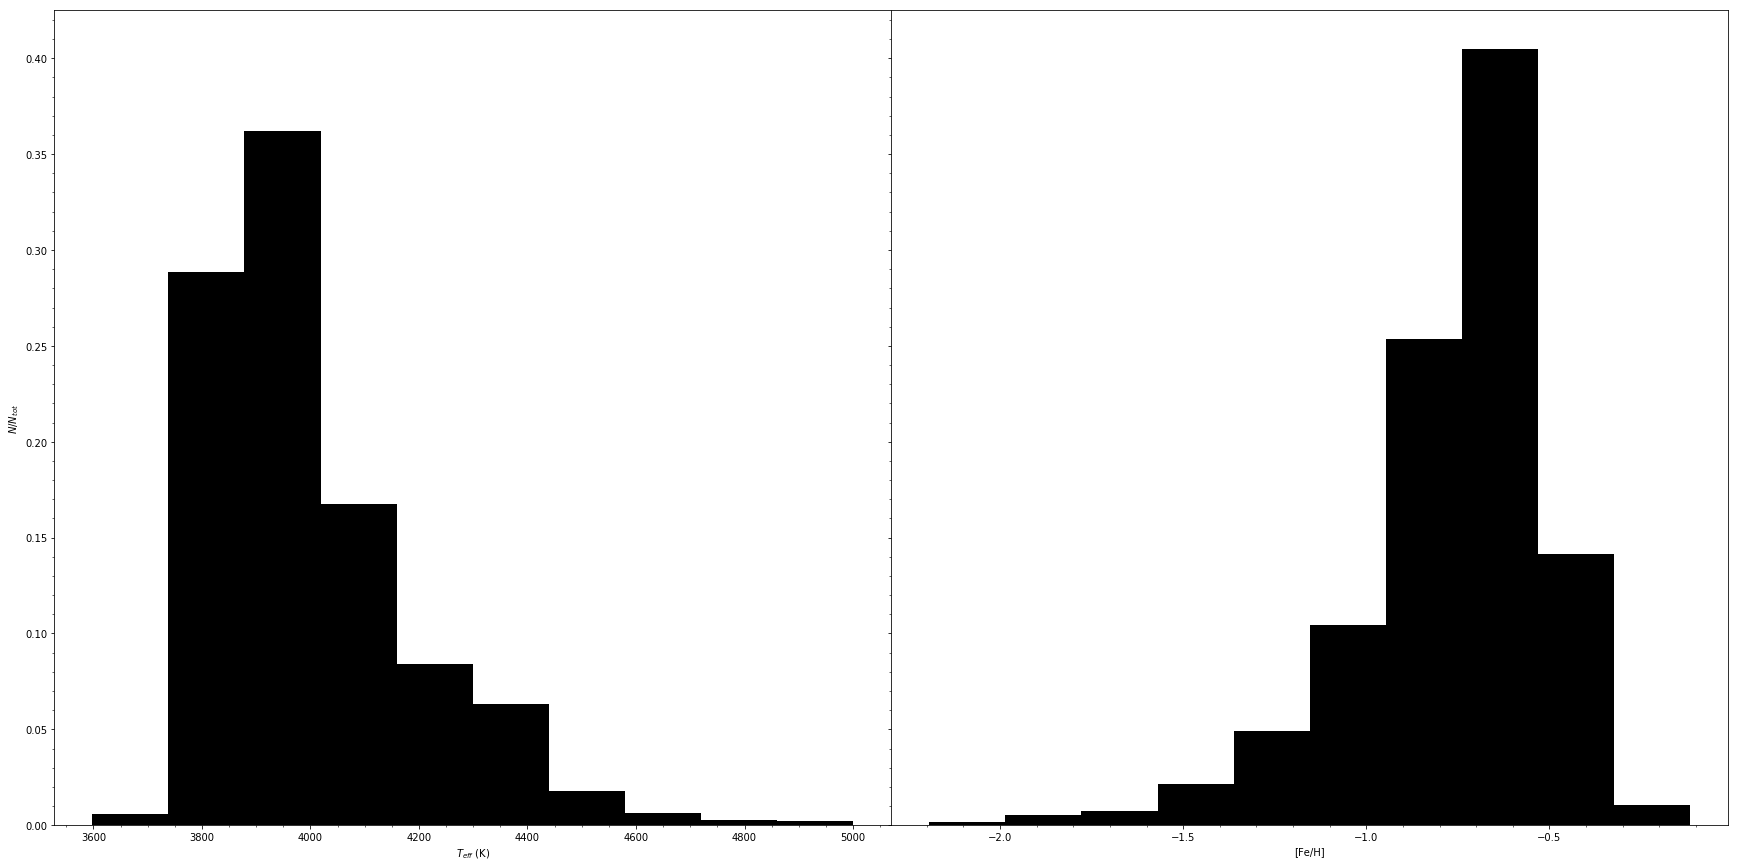

In [4]:
##############################################
### Temperature and Metallicity Histograms ###
##############################################

f, ax = plt.subplots(1,2,sharey=True,facecolor='w',figsize=(30,15))
teffweights = np.ones_like(r13['TEFF'])/float(len(r13['TEFF']))
fehweights = np.ones_like(r13['FE_H'])/float(len(r13['FE_H']))
ax[0].hist(r13['TEFF'],color='k',weights=teffweights)
ax[0].set_xlabel(r'$T_{eff}$ (K)')
ax[0].set_ylabel(r'$N/N_{tot}$')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].hist(r13['FE_H'],color='k',weights=fehweights)
ax[1].set_xlabel(r'[Fe/H]')
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [5]:
##########################################
### Calculate Gradients and intercepts ###
##########################################

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

### A matrix in Ax=b
# A = np.vstack([r13['LMCRAD']*0.875,np.ones(len(r13['LMCRAD']))]).T

elems_slope = []
elems_inter = []

for i in range(len(elems)):
    cln = np.where(r13[elems[i]]>-100)
    A = np.vstack([r13['LMCRAD'][cln]*0.875,np.ones(len(r13['LMCRAD'][cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13[elems[i]][cln])[0]
    elems_slope.append(mi)
    elems_inter.append(ci)
    
for j in range(len(elems)):
    print(elems[j]+' slope: '+str(elems_slope[j])+ ' inter: '+ str(elems_inter[j]))

M_H slope: -0.04469746106580041 inter: -0.5854986994582714
C_FE slope: -0.01590609637670355 inter: -0.283696062921988
N_FE slope: -0.02061686597763789 inter: 0.2090189129573981
O_FE slope: 0.0040382246539376115 inter: 0.019986108826921624
NA_FE slope: 0.008458814111490864 inter: -0.22203953064219212
MG_FE slope: -0.0008666839417662938 inter: 0.10908725950915502
AL_FE slope: -0.012401801809783886 inter: -0.31095589182831007
SI_FE slope: 0.008699766610125474 inter: -0.027787762109390518
P_FE slope: 0.034458673213964584 inter: -0.07109358533214162
S_FE slope: 0.0032619080116273063 inter: 0.1495665028341906
K_FE slope: -0.004861357969901275 inter: 0.022286934280894174
CA_FE slope: -0.0041804933773774405 inter: 0.10966834965410402
TI_FE slope: -0.0005231024626502212 inter: -0.11013977622493219
TIII_FE slope: 0.007694784761936883 inter: -0.09093815940615059
V_FE slope: -0.019789303386937396 inter: -0.08229312824910856
CR_FE slope: -0.023225603755944735 inter: 0.08695561038147588
MN_FE slope:

In [6]:
###############################
### Add Noise to Abundances ###
###############################

def noisy(abund,abund_err):
    
    '''
    - abund: abundnace to add noise to
    - abund_err: error in abund
    '''

    abundnoise = np.random.normal(0,scale=abund_err)
    abundnew = abund + abundnoise

    return abundnew

In [66]:
########################################
### Calculate Gradient Uncertainties ###
########################################

elems_m_devs = []
elems_b_devs = []

Adevs = []
elems_values = []
elems_errors = []
for i in range(len(elems)):
    cln = np.where(r13[elems[i]]>-100)
    Adevs.append(np.vstack([r13['LMCRAD'][cln]*0.875,np.ones(len(r13['LMCRAD'][cln]))]).T)
    elems_values.append(r13[elems[i]][cln])
    elems_errors.append(r13[elems[i]+str('_ERR')][cln])

# slopes = []
noisy_values = []
m_devs = []
b_devs = []
for j in range(len(elems)):
    slopes = []
    inters = []
    for k in range(1000):
        mi, bi = np.linalg.lstsq(Adevs[j], noisy(elems_values[j],elems_errors[j]))[0]
        slopes.append(mi)
        inters.append(bi)
    m_devs.append(mad(slopes))
    b_devs.append(mad(inters))

In [61]:
##############################################
### Summary Print Out of Error Calculation ###
##############################################

elem_where = dict(zip(elems,range(len(elems))))
print(elem_where)
print('=== Slope ===')
print(elems_slope)
print('=== Slope Error ===')
print(m_devs)
print('=== Inter ===')
print(elems_inter)
print('=== Inter Error ===')
print(b_devs)

{'M_H': 0, 'C_FE': 1, 'N_FE': 2, 'O_FE': 3, 'NA_FE': 4, 'MG_FE': 5, 'AL_FE': 6, 'SI_FE': 7, 'P_FE': 8, 'S_FE': 9, 'K_FE': 10, 'CA_FE': 11, 'TI_FE': 12, 'TIII_FE': 13, 'V_FE': 14, 'CR_FE': 15, 'MN_FE': 16, 'FE_H': 17, 'CO_FE': 18, 'NI_FE': 19, 'CU_FE': 20, 'GE_FE': 21, 'RB_FE': 22, 'CE_FE': 23, 'ND_FE': 24, 'YB_FE': 25}
=== Slope ===
[-0.04469746106580041, -0.01590609637670355, -0.02061686597763789, 0.0040382246539376115, 0.008458814111490864, -0.0008666839417662938, -0.012401801809783886, 0.008699766610125474, 0.034458673213964584, 0.0032619080116273063, -0.004861357969901275, -0.0041804933773774405, -0.0005231024626502212, 0.007694784761936883, -0.019789303386937396, -0.023225603755944735, -0.036177738474544106, -0.04111475439388108, -0.01651992829290966, -0.0035659931209193747, 0.01782622190684733, 0.0, 0.0, 0.0, 0.0, 0.0]
=== Slope Error ===
[0.00011712994912962613, 0.00015795625812070266, 0.00026827361057089535, 0.00015950657884821482, 0.0006893934334362617, 0.00018607650421896, 0.

In [9]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [10]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMC(r13['RA'],r13['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(r13['K'],stardist)-r13['AK_TARG']
parage = parsec_age(np.log10(r13['TEFF']),corabsK,sal(r13['M_H'],metscorr),r13['LOGG'])
parage = np.squeeze(parage)

In [11]:
len(r13)

2427

In [12]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [13]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(r13)):
    lgT = np.log10(r13['TEFF'][i])
    lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
    ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
    mhERR = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfeERR = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
    lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

In [14]:
# print(elems)

In [15]:
14/4

3.5

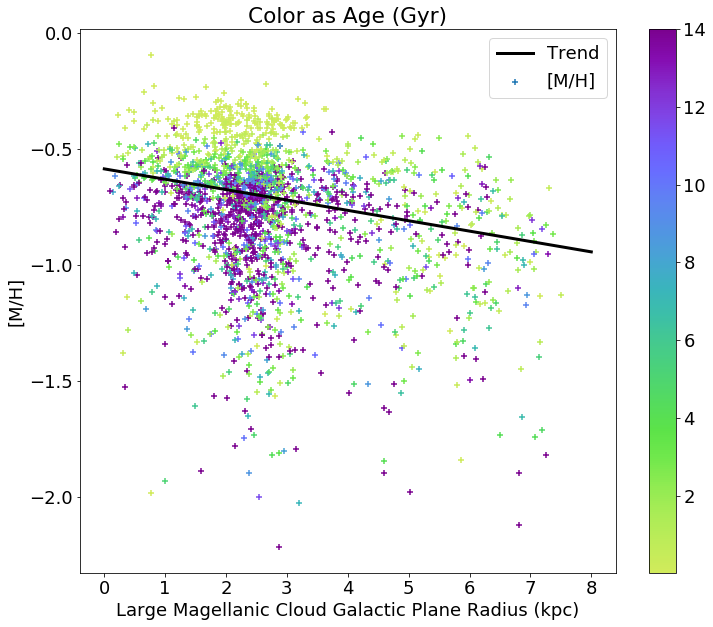

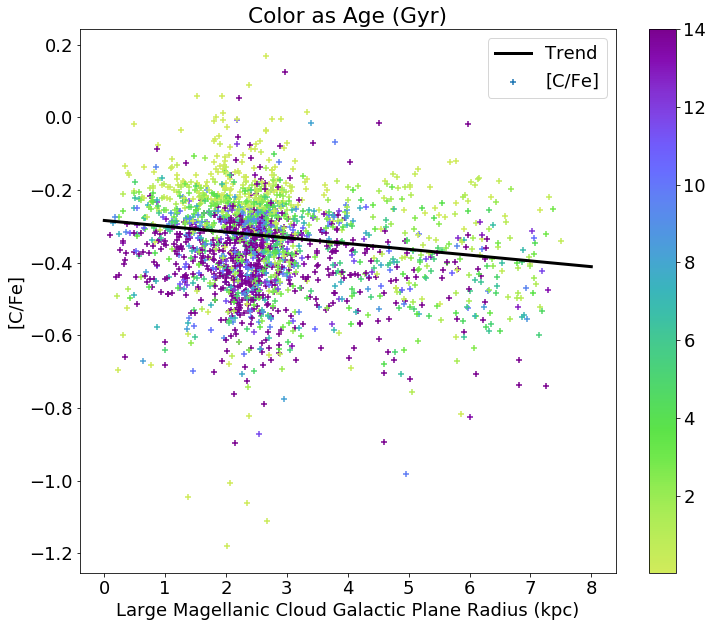

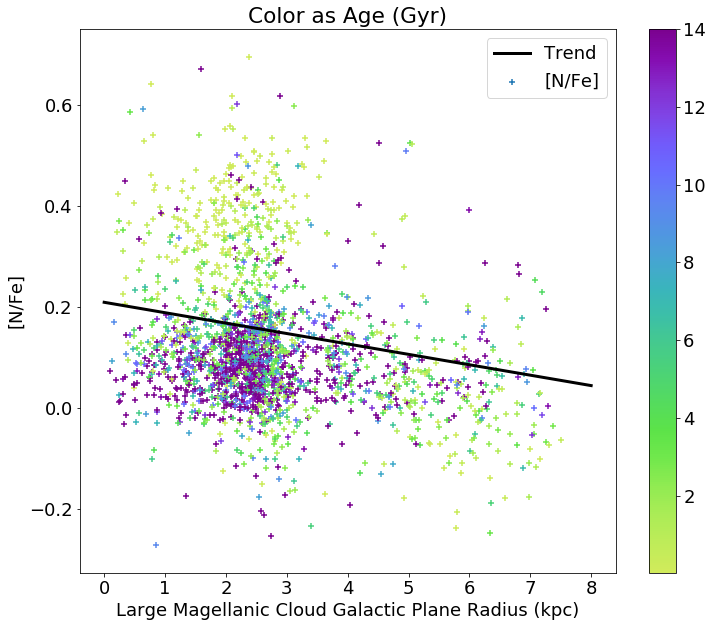

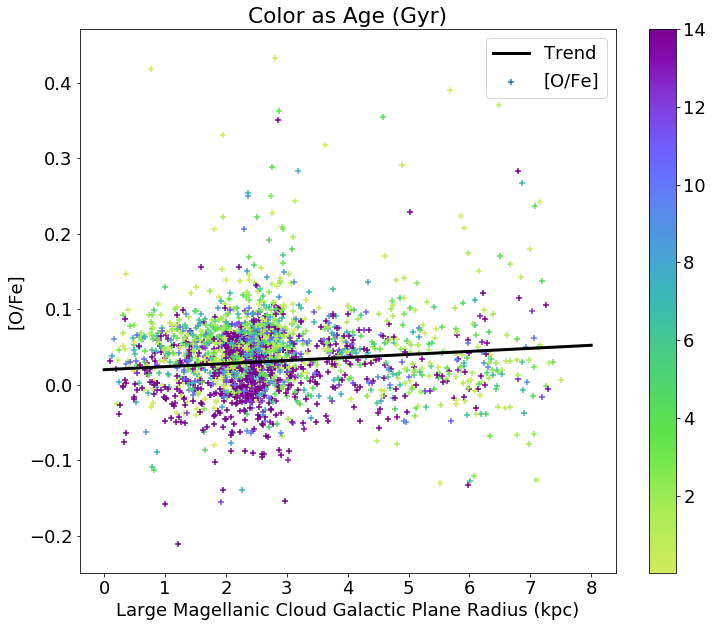

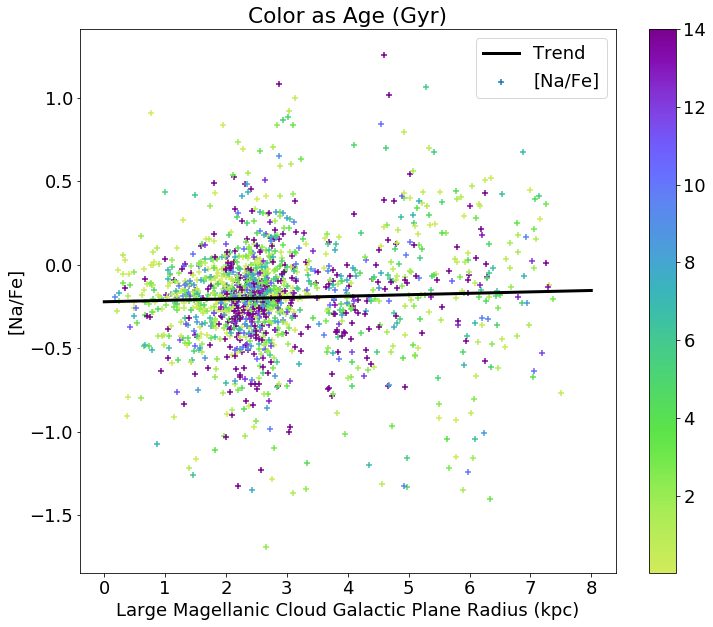

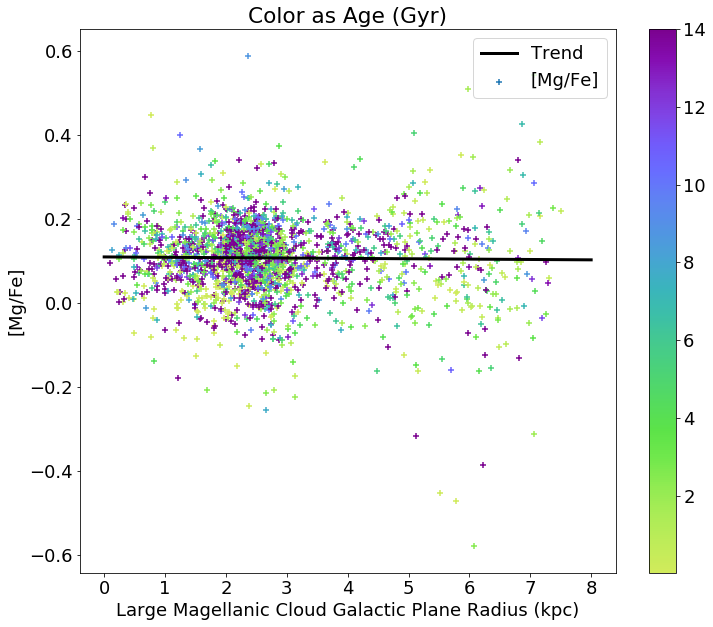

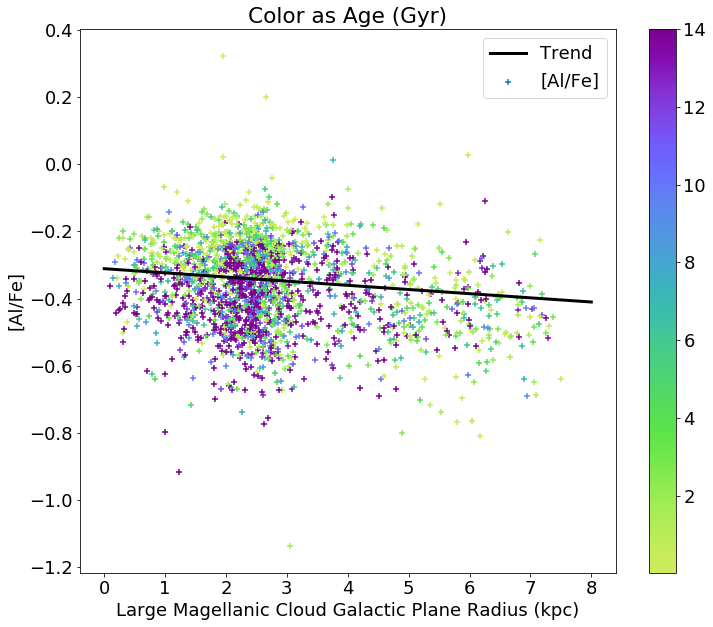

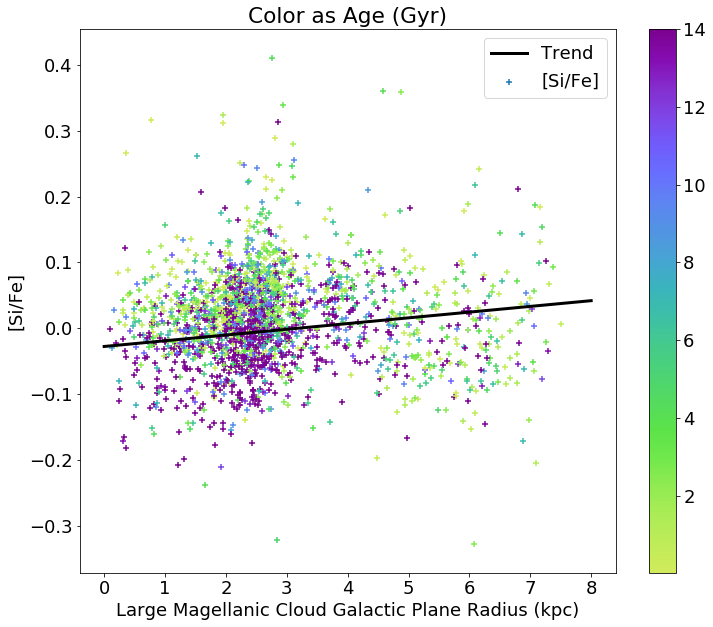

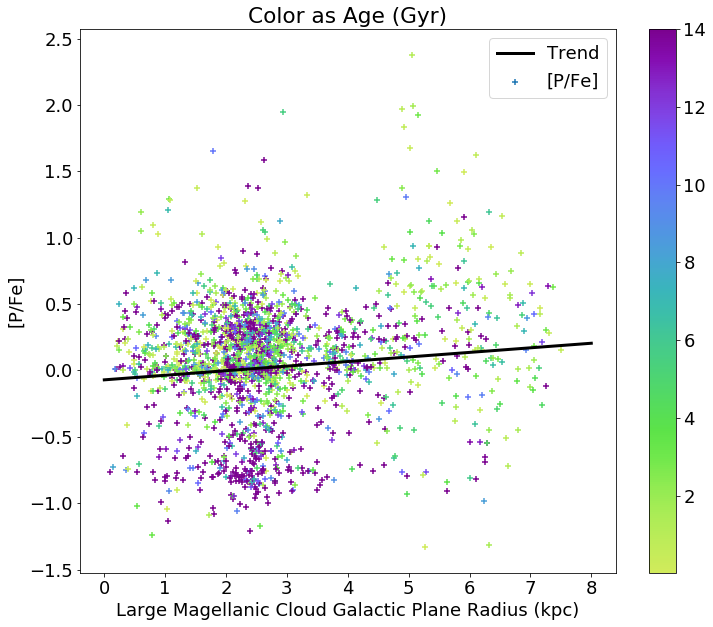

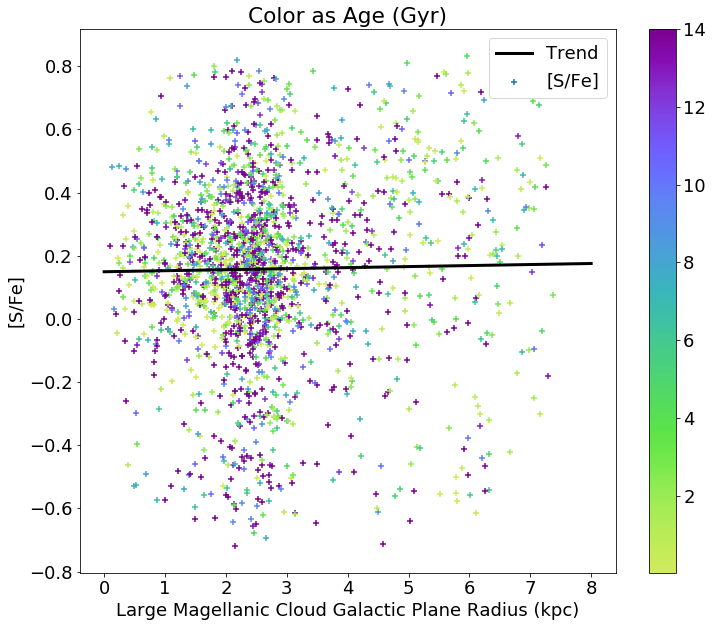

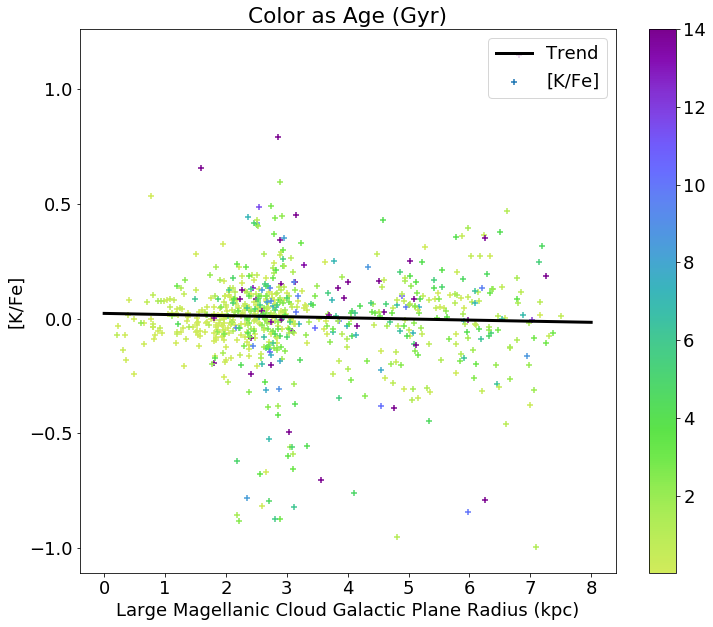

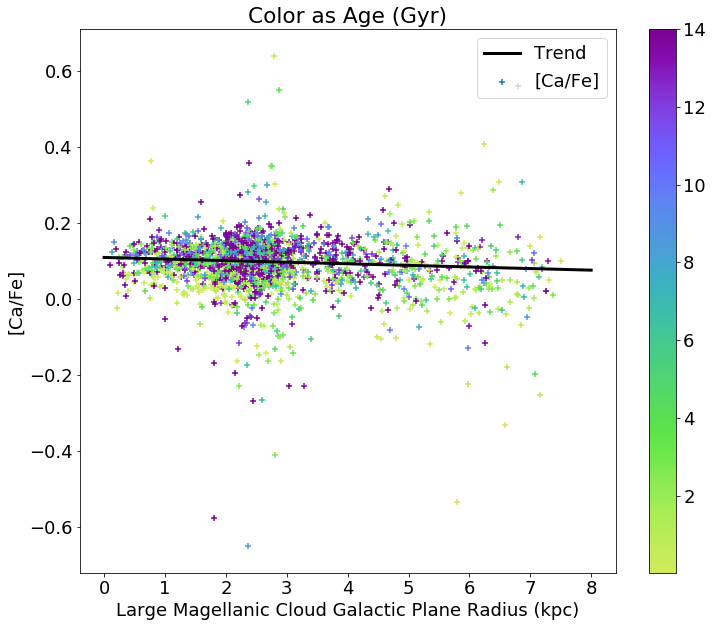

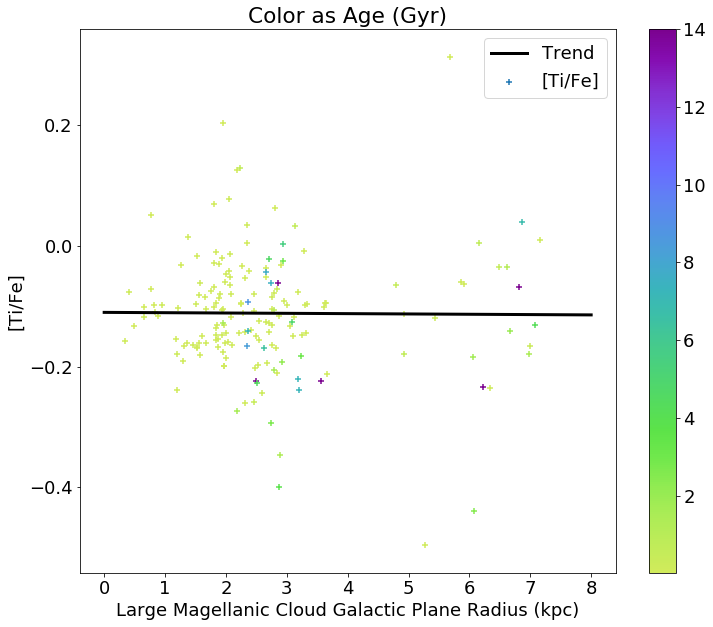

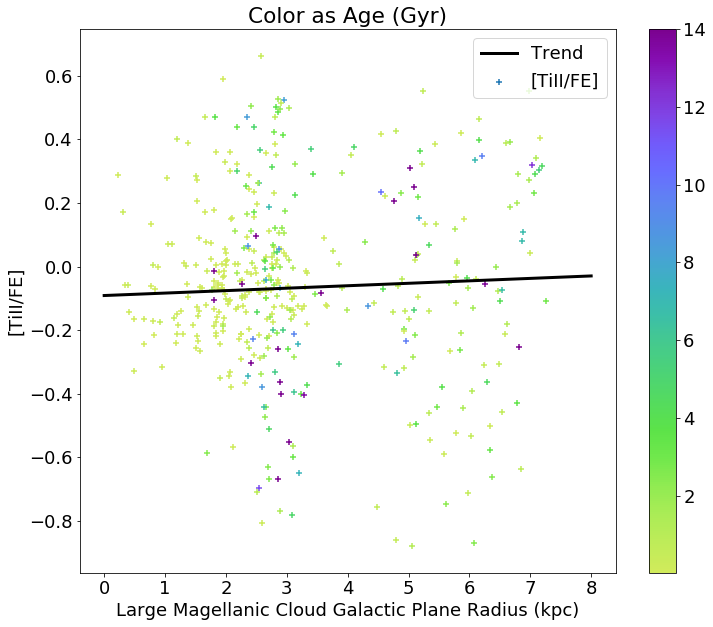

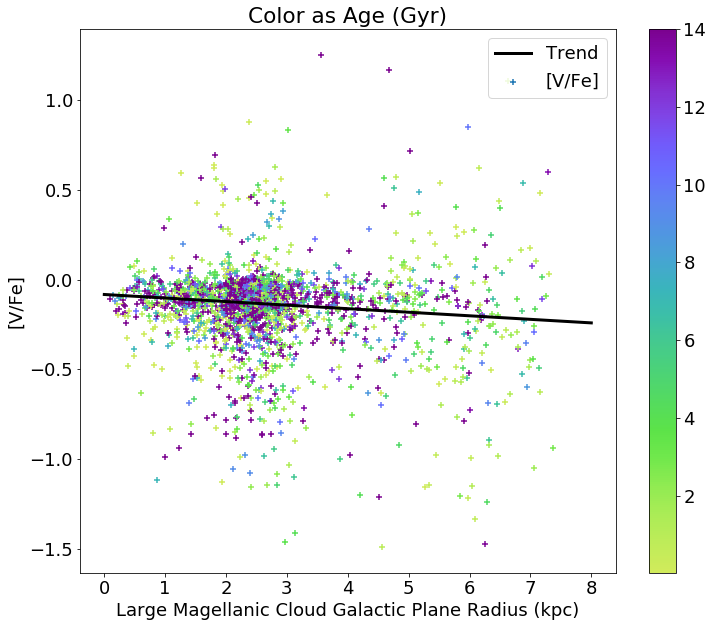

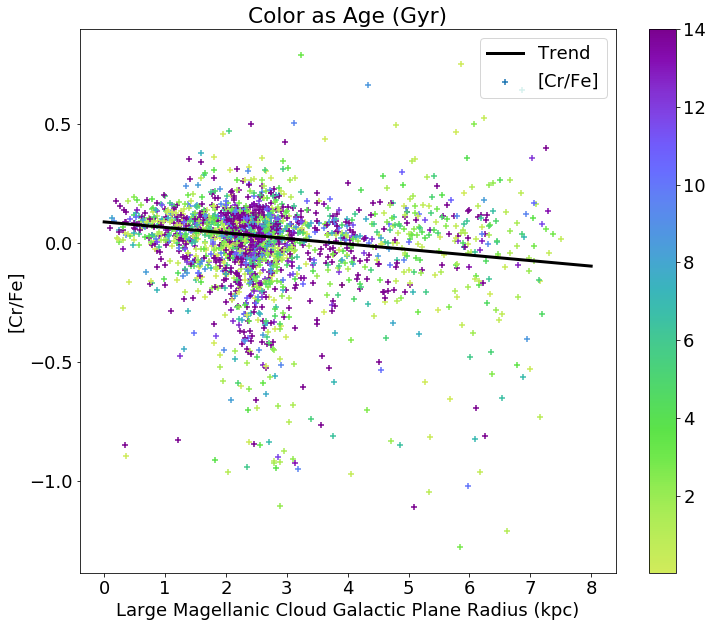

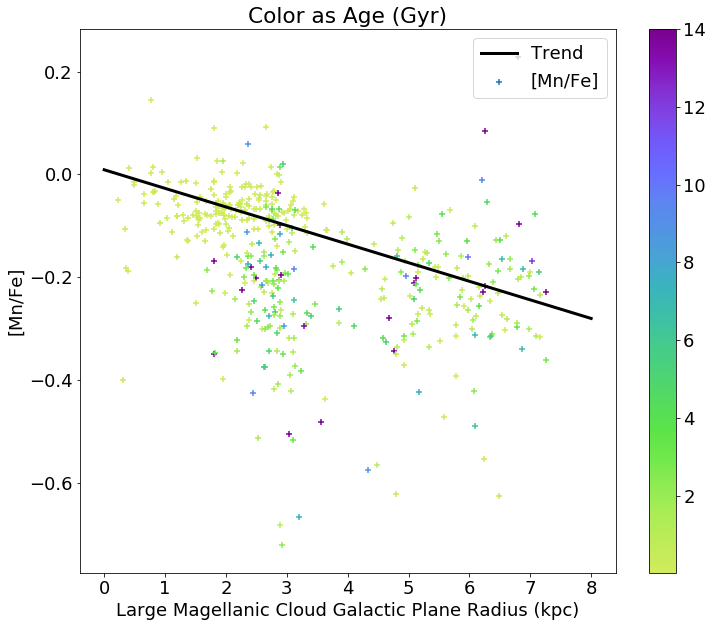

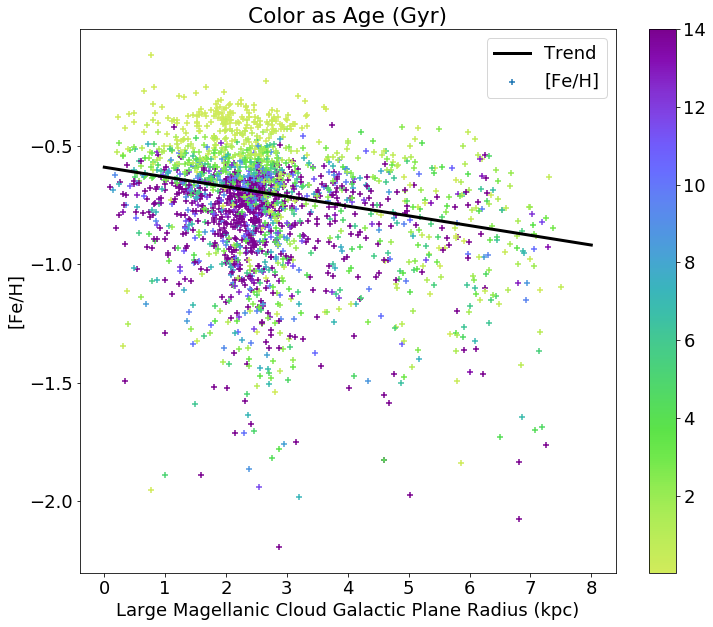

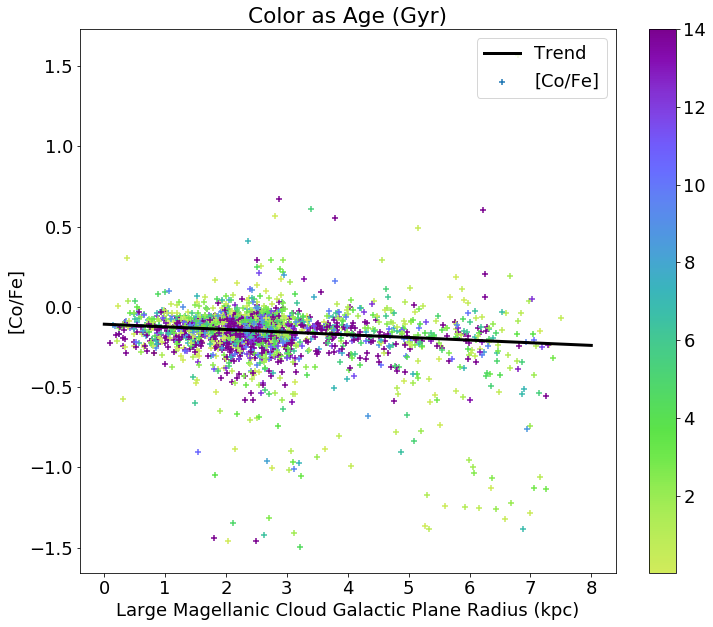

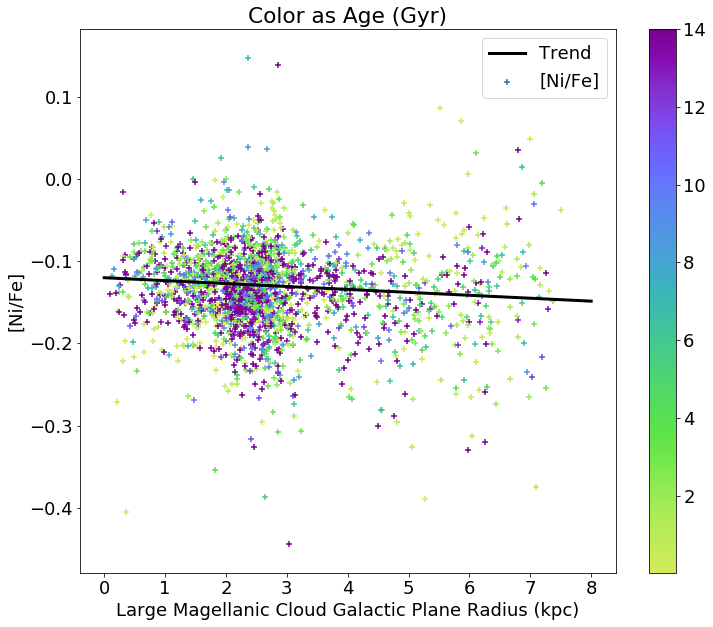

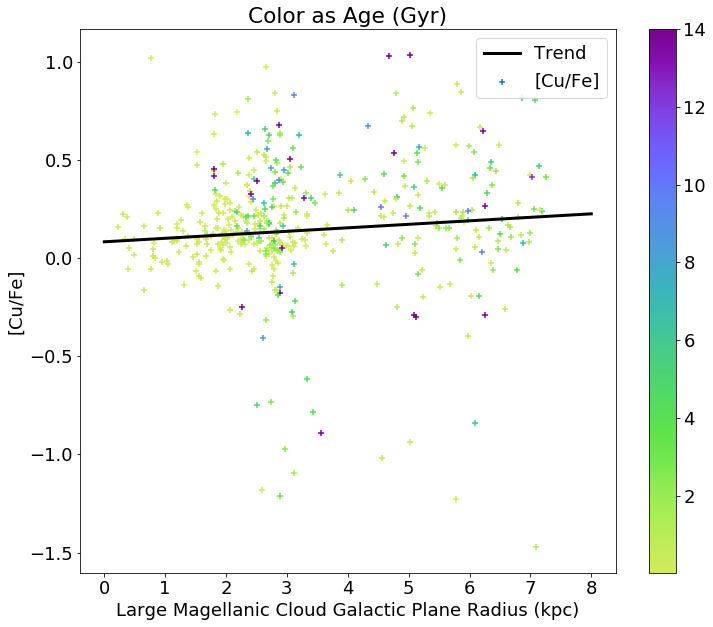

In [16]:
# import scipy.stats as st

radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1])

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

matplotlib.rcParams.update({'font.size': 18})
for i in range(len(elems)-5):
    xval = np.linspace(0.0,8.0)
    def trendline(x):
        return elems_slope[i]*x+elems_inter[i]
    cln = np.where(r13[elems[i]]>-100)
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln],r13[elems[i]][cln],marker='+',c=(10**parage[cln])/10**9,label='{}'.format(labs[i]),
                cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,vmax=14)
    plt.plot(xval,trendline(xval),c='k',lw=3.0,label='Trend')
    plt.legend(loc='upper right')
    plt.title(r'Color as Age (Gyr)')
    plt.ylabel(r'{}'.format(labs[i]))
    plt.xlabel(r'Large Magellanic Cloud Galactic Plane Radius (kpc)')
    plt.colorbar()

$\Huge{\text{AGE BINS BELOW}}$

In [17]:
################
### Age Bins ###
################

young = np.where(parage<=np.log10(3.5*10**9))
ymed = np.where((parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))
# print(ymed)

In [29]:
##########################################
### Calculate Gradients and intercepts ###
##########################################

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']


### young ###
young_elems_slope = []
young_elems_inter = []

r13young = r13[young]

for i in range(len(elems)):
    cln = np.where(r13young[elems[i]]>-100)
    A = np.vstack([r13young['LMCRAD'][cln]*0.875,np.ones(len(r13young['LMCRAD'][cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13young[elems[i]][cln])[0]
    young_elems_slope.append(mi)
    young_elems_inter.append(ci)
    
print('### young Age <= 3.5  Gyr ###')

for j in range(len(elems)):
    print(elems[j]+' slope: '+str(young_elems_slope[j])+ ' inter: '+ str(young_elems_inter[j]))

### ymed ###
print('### ymed  3.5< Age <=7.0 Gyr ###')
ymed_elems_slope = []
ymed_elems_inter = []

r13ymed = r13[ymed]

for i in range(len(elems)):
    cln = np.where(r13ymed[elems[i]]>-100)
    A = np.vstack([r13ymed['LMCRAD'][cln]*0.875,np.ones(len(r13ymed['LMCRAD'][cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13ymed[elems[i]][cln])[0]
    ymed_elems_slope.append(mi)
    ymed_elems_inter.append(ci)
    
for j in range(len(elems)):
    print(elems[j]+' slope: '+str(ymed_elems_slope[j])+ ' inter: '+ str(ymed_elems_inter[j]))
    
### omed ###
print('### omed  7.0< Age <=10.5 Gyr ###')
omed_elems_slope = []
omed_elems_inter = []

r13omed = r13[omed]

for i in range(len(elems)):
    cln = np.where(r13omed[elems[i]]>-100)
    A = np.vstack([r13omed['LMCRAD'][cln]*0.875,np.ones(len(r13omed['LMCRAD'][cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13omed[elems[i]][cln])[0]
    omed_elems_slope.append(mi)
    omed_elems_inter.append(ci)
    
# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(omed_elems_slope[j])+ ' inter: '+ str(omed_elems_inter[j]))
    
### old ###
print('### old  10.5< Age Gyr ###')
old_elems_slope = []
old_elems_inter = []

r13old = r13[old]

for i in range(len(elems)):
    cln = np.where(r13old[elems[i]]>-100)
    A = np.vstack([r13old['LMCRAD'][cln]*0.875,np.ones(len(r13old['LMCRAD'][cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13old[elems[i]][cln])[0]
    old_elems_slope.append(mi)
    old_elems_inter.append(ci)
    
for j in range(len(elems)):
    print(elems[j]+' slope: '+str(old_elems_slope[j])+ ' inter: '+ str(old_elems_inter[j]))

### young Age <= 3.5  Gyr ###
M_H slope: -0.08028974776594051 inter: -0.30798503869880905
C_FE slope: -0.02425138319984136 inter: -0.18391221987959722
N_FE slope: -0.052722749319717745 inter: 0.4115838202322544
O_FE slope: 0.005441078804598747 inter: 0.027661042055561573
NA_FE slope: 0.004067887050734306 inter: -0.1889879474672453
MG_FE slope: 0.0022008522335760037 inter: 0.08288608389185108
AL_FE slope: -0.027351707555224092 inter: -0.20267139013194707
SI_FE slope: 0.005436455123139187 inter: 0.008383723691326773
P_FE slope: 0.02822699484452172 inter: 0.058963658400820136
S_FE slope: 0.012365358851997285 inter: 0.1258299973731298
K_FE slope: -0.00052239225977763 inter: -0.002178414044408579
CA_FE slope: -0.0026473361720824157 inter: 0.0829683259976221
TI_FE slope: 0.0007898330933165329 inter: -0.11159106707598569
TIII_FE slope: 0.012616014236561479 inter: -0.11346039796487588
V_FE slope: -0.0174781179575081 inter: -0.10897888992109317
CR_FE slope: -0.025007045418280353 inter: 0.083424

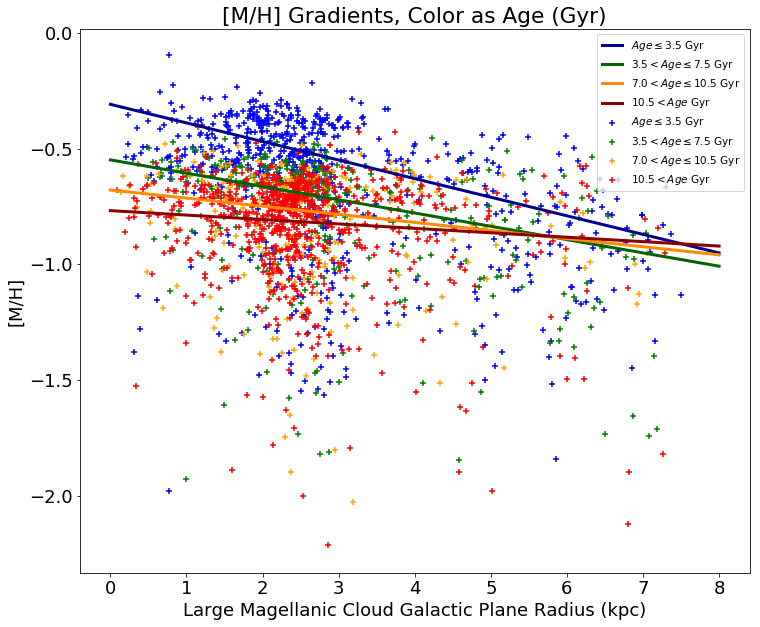

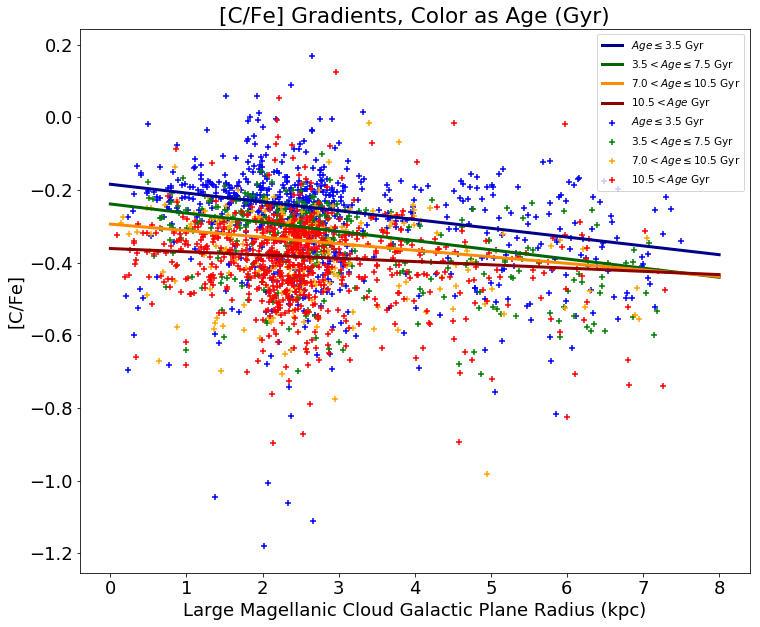

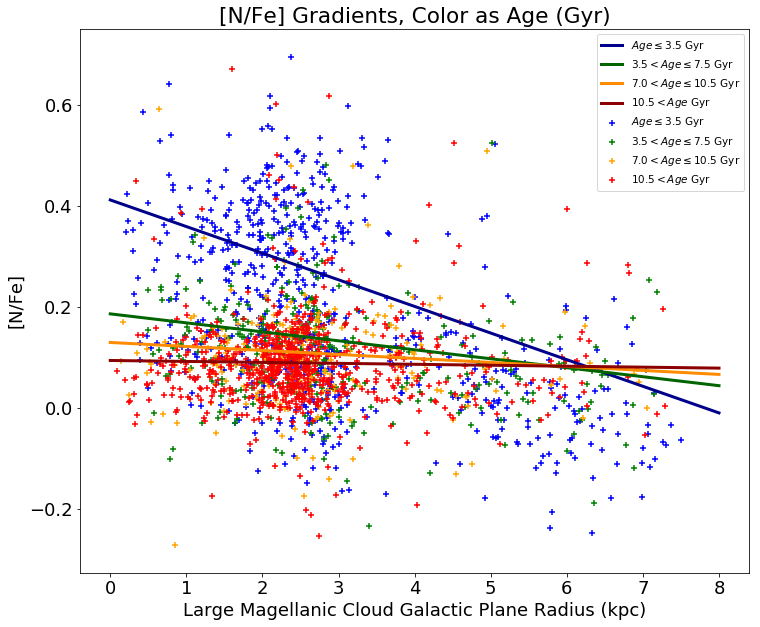

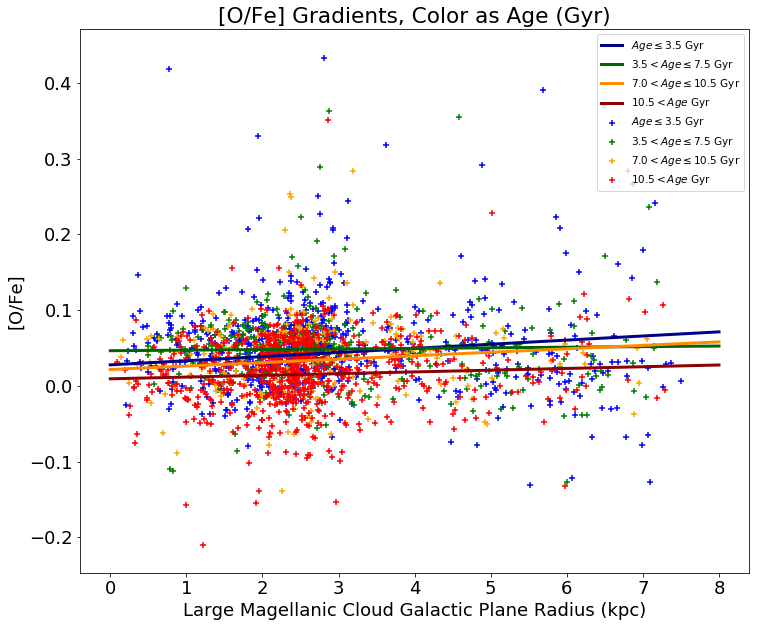

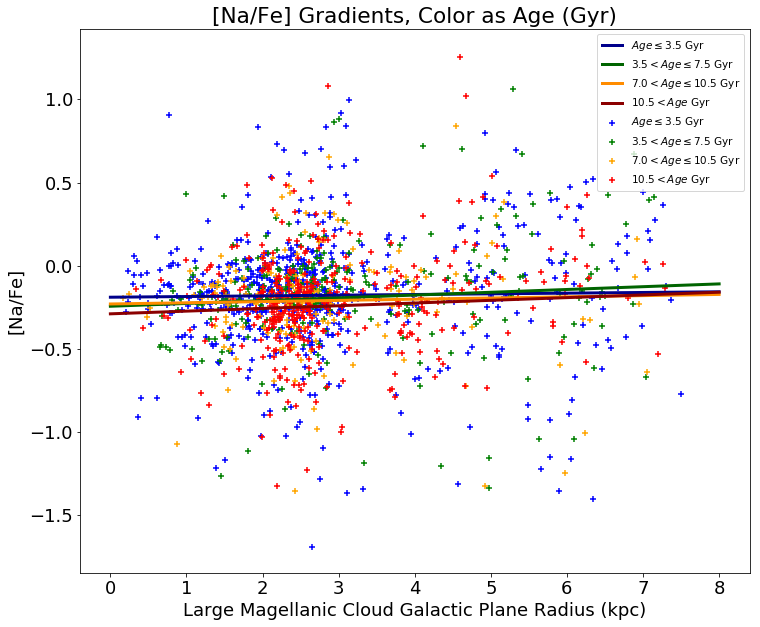

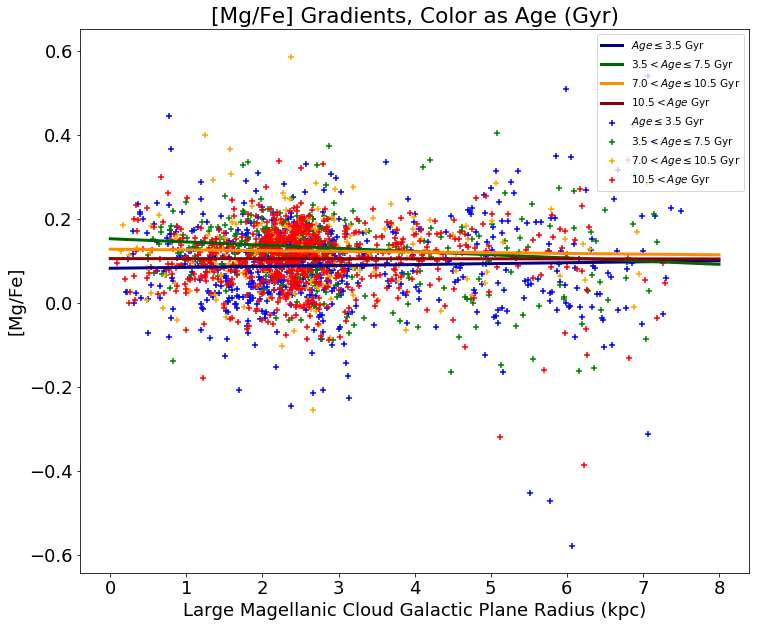

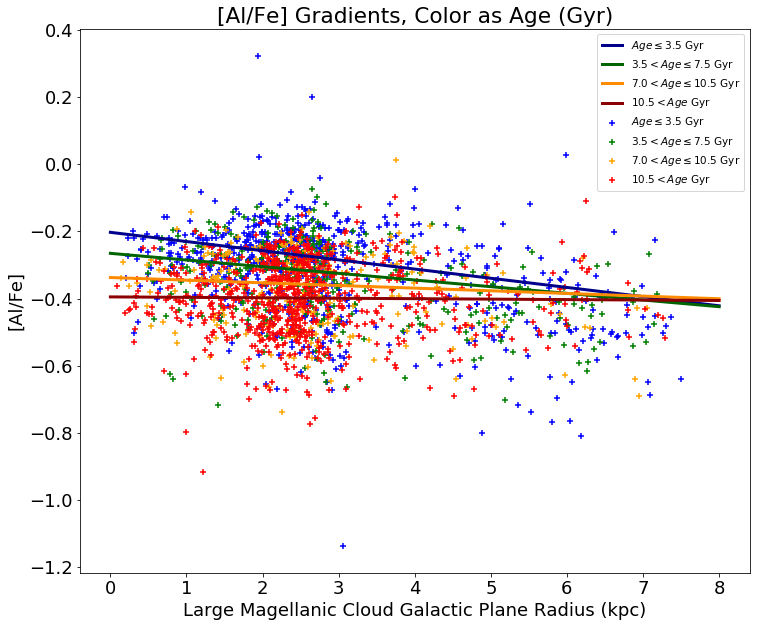

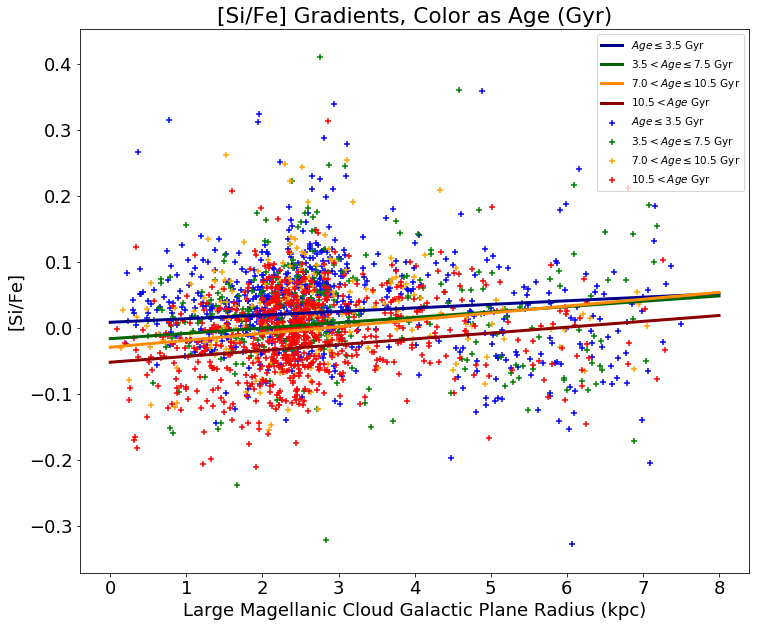

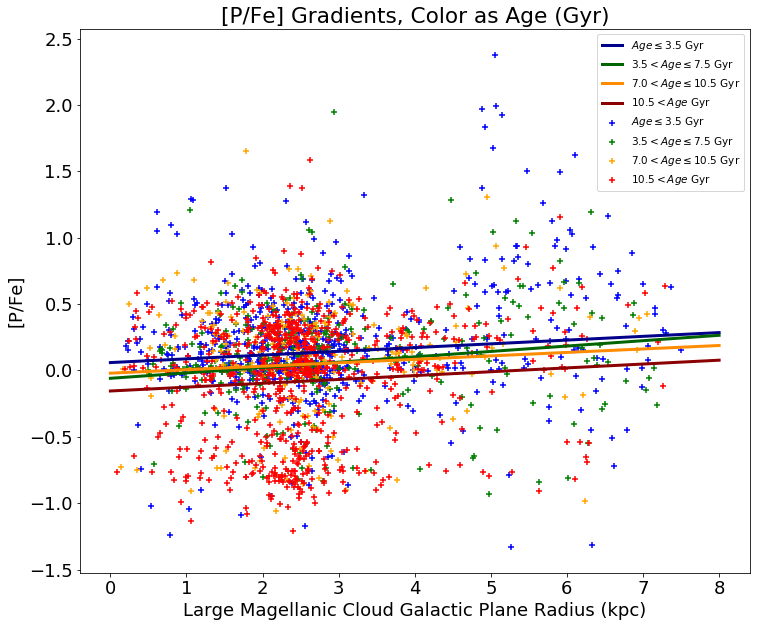

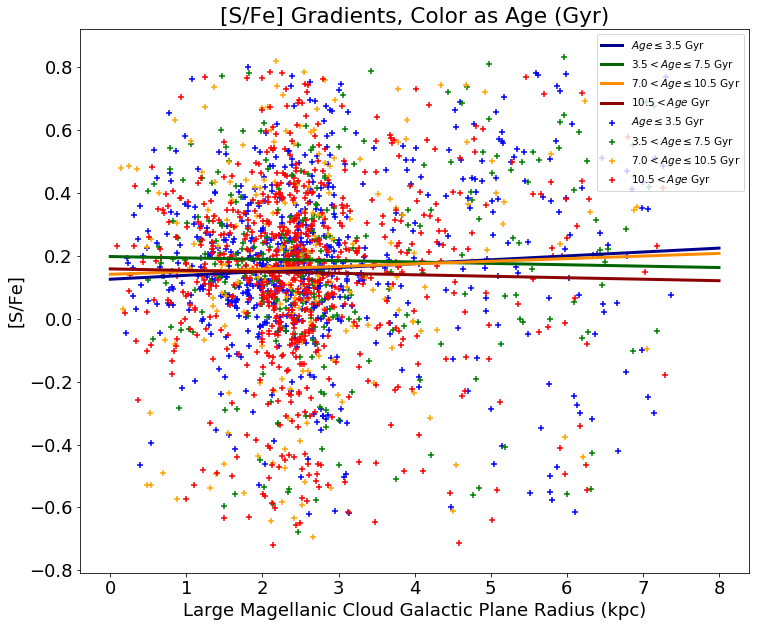

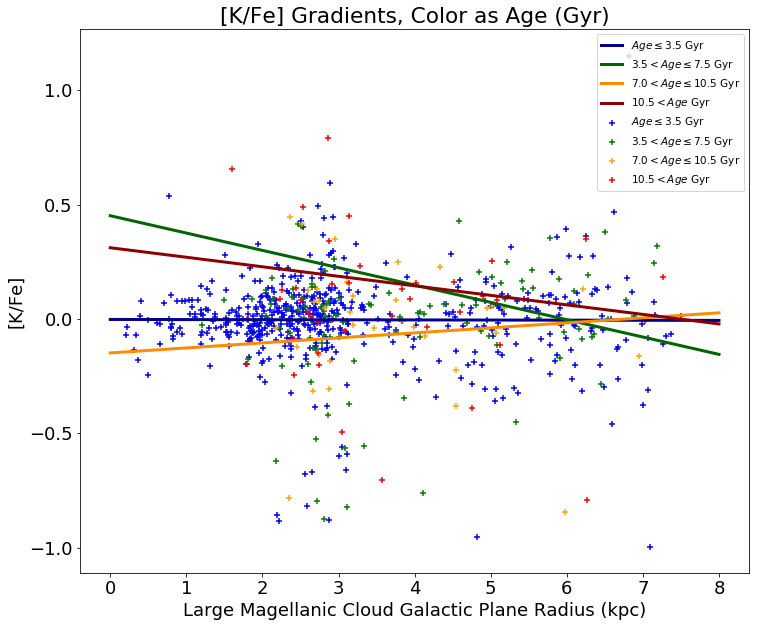

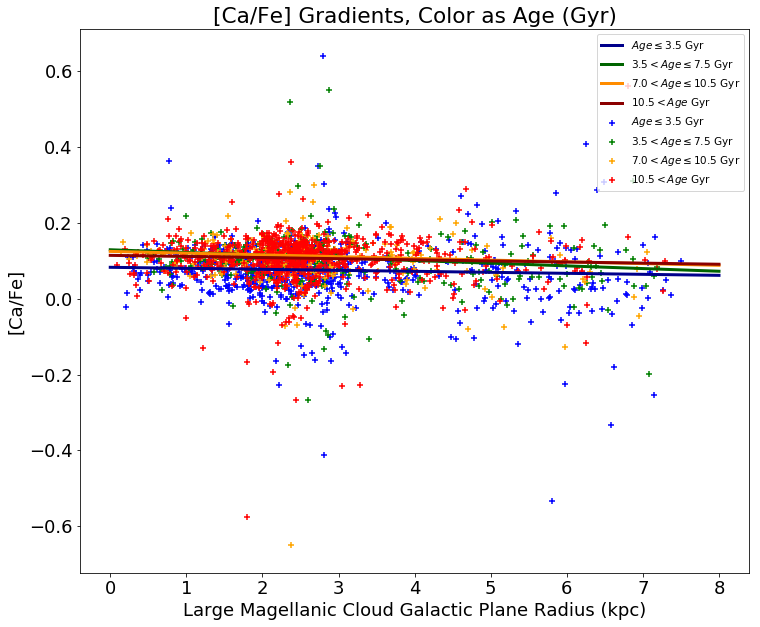

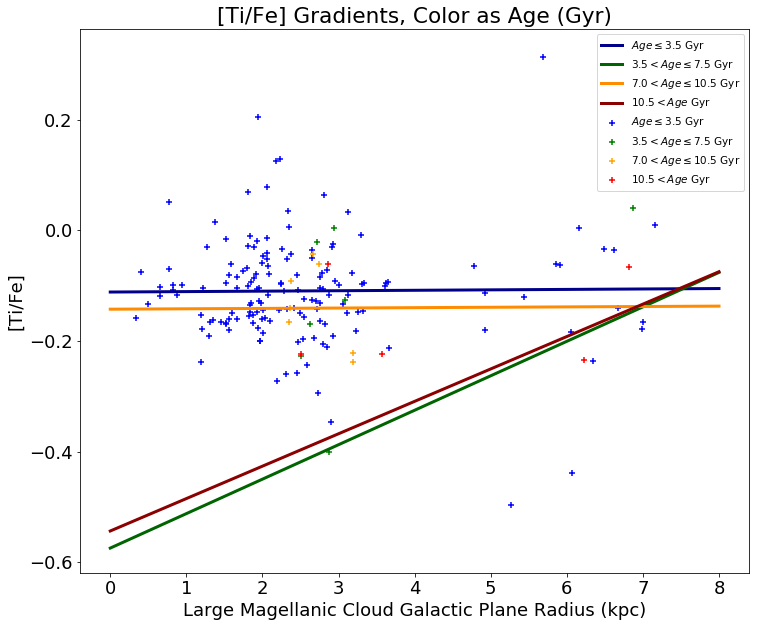

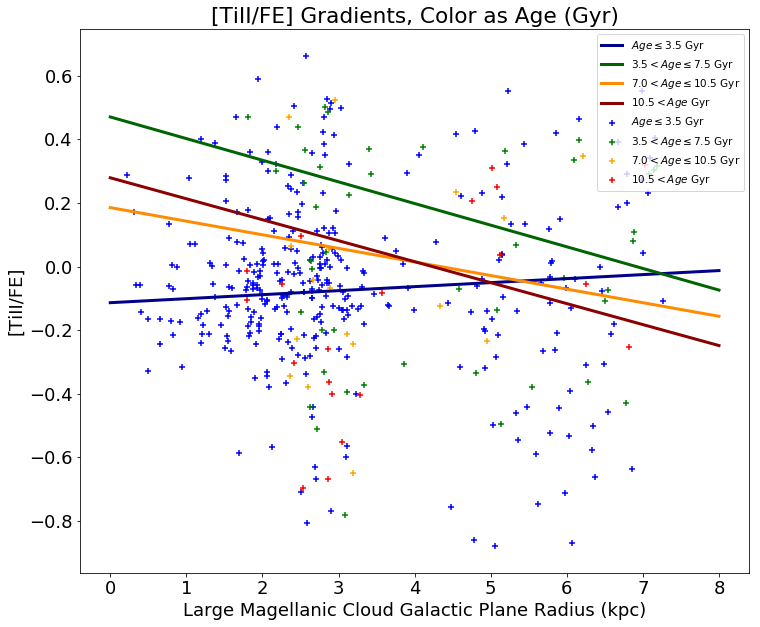

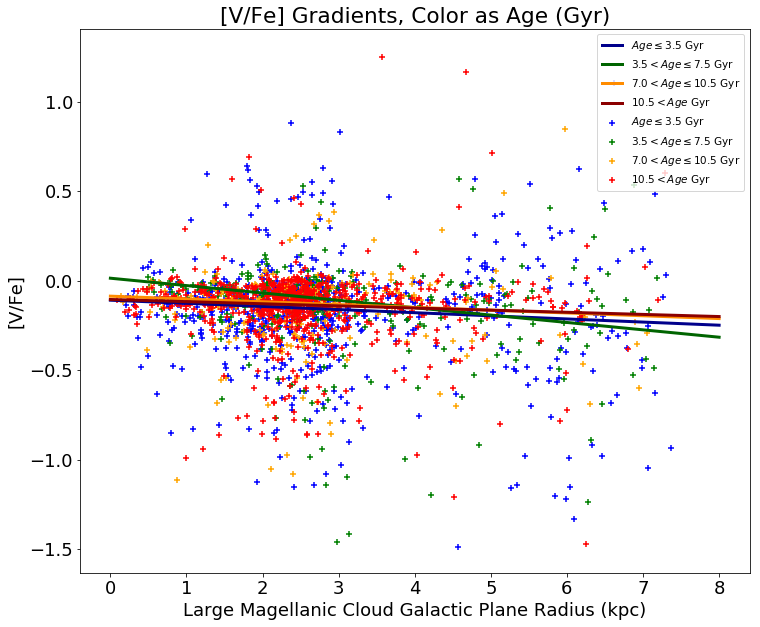

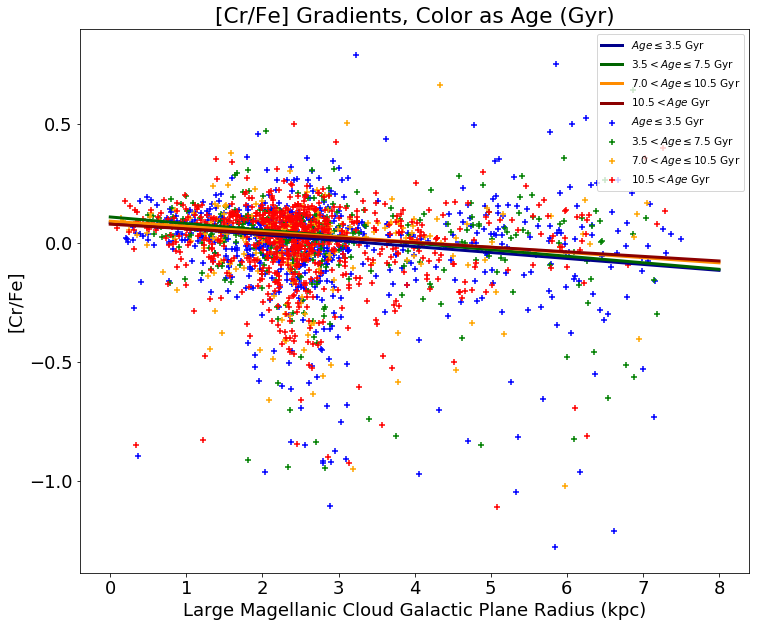

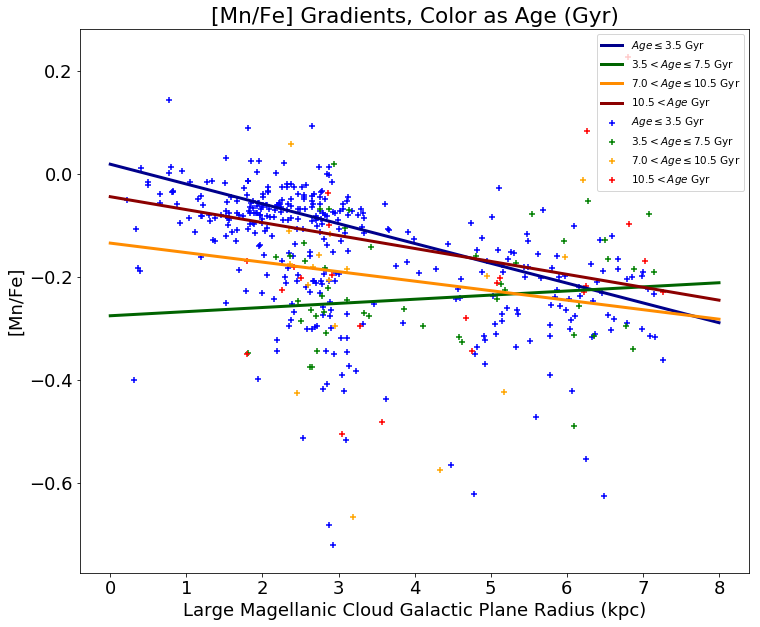

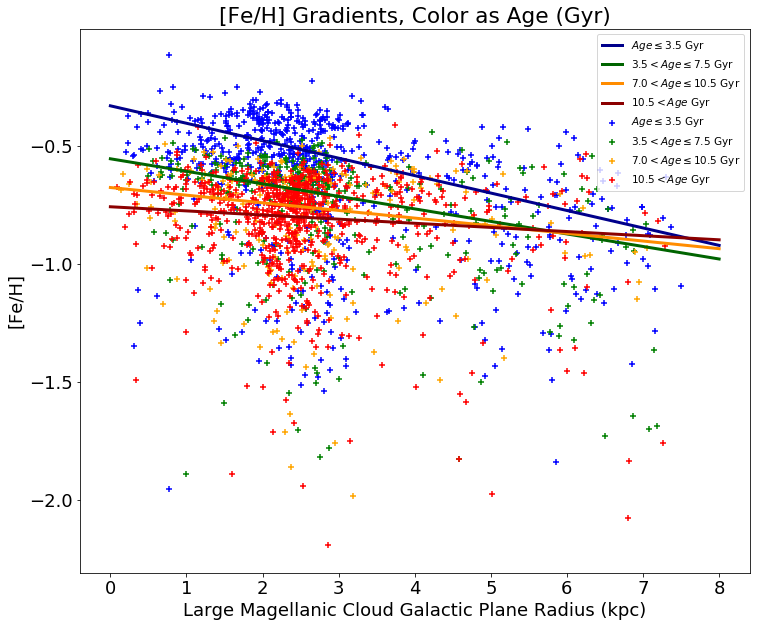

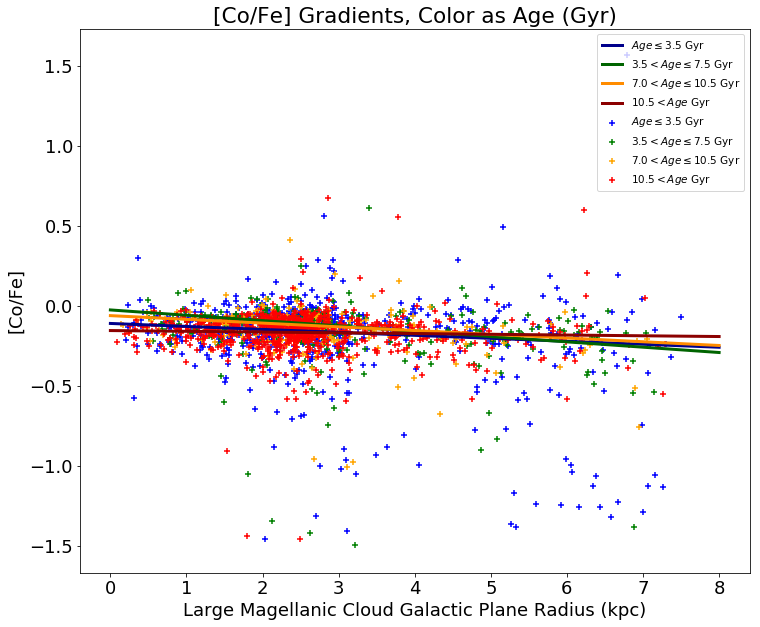

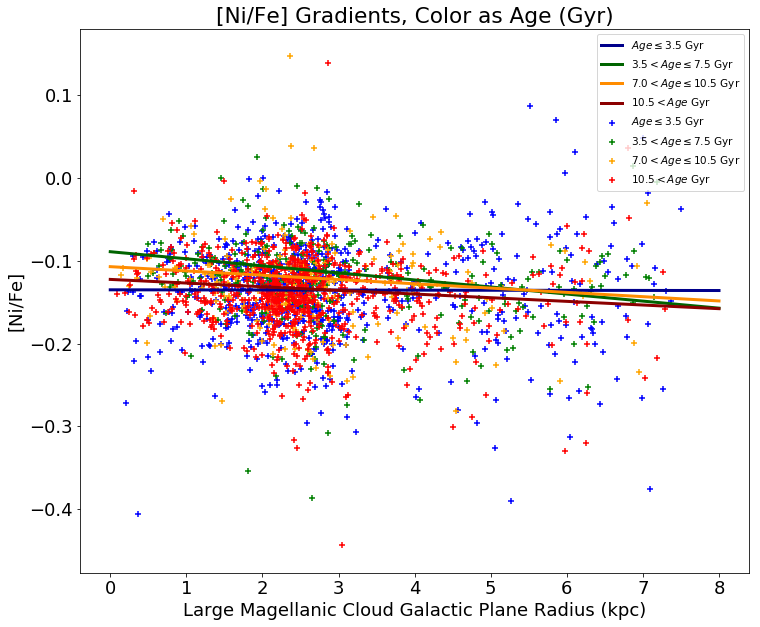

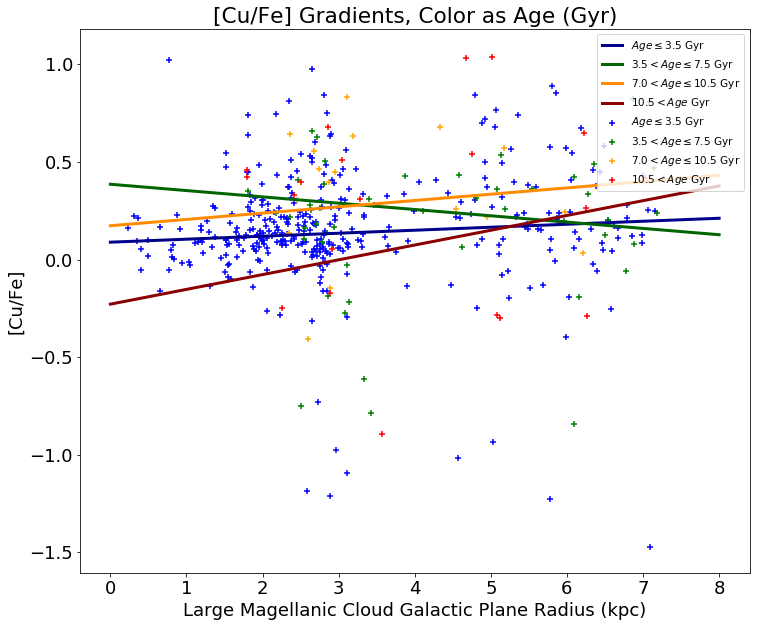

In [76]:
radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1])

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

matplotlib.rcParams.update({'font.size': 18})

young_parage = parage[young]
ymed_parage = parage[ymed]
omed_parage = parage[omed]
old_parage = parage[old]

for i in range(len(elems)-5):
    xval = np.linspace(0.0,8.0)
    
    def youngtrendline(x):
        return young_elems_slope[i]*x+young_elems_inter[i]
    def ymedtrendline(x):
        return ymed_elems_slope[i]*x+ymed_elems_inter[i]
    def omedtrendline(x):
        return omed_elems_slope[i]*x+omed_elems_inter[i]
    def oldtrendline(x):
        return old_elems_slope[i]*x+old_elems_inter[i]
    
    young_cln = np.where(r13young[elems[i]]> -100)
    ymed_cln = np.where(r13ymed[elems[i]]> -100)
    omed_cln = np.where(r13omed[elems[i]]> -100)
    old_cln = np.where(r13old[elems[i]]> -100)
    
    plt.figure(figsize=[12,10])
    
    plt.scatter(radius[young][young_cln],r13young[elems[i]][young_cln],marker='+',label='$Age \leq 3.5$ Gyr',
                c='blue')
    plt.plot(xval,youngtrendline(xval),c='darkblue',lw=3.0,label='$Age \leq 3.5$ Gyr') #young
    
    plt.scatter(radius[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],marker='+',label='$3.5 < Age \leq 7.5$ Gyr',
                c='green')
    plt.plot(xval,ymedtrendline(xval),c='darkgreen',lw=3.0,label='$3.5 < Age \leq 7.5$ Gyr') #ymed
    
    plt.scatter(radius[omed][omed_cln],r13omed[elems[i]][omed_cln],marker='+',label='$7.0 < Age \leq 10.5$ Gyr',
                c='orange')
    plt.plot(xval,omedtrendline(xval),c='darkorange',lw=3.0,label='$7.0 < Age \leq 10.5$ Gyr') #omed
    
    plt.scatter(radius[old][old_cln],r13old[elems[i]][old_cln],marker='+',label='$10.5 < Age$ Gyr',
                c='red')
    plt.plot(xval,oldtrendline(xval),c='darkred',lw=3.0,label='$10.5 < Age$ Gyr') #old
   
    plt.legend(loc='upper right',fontsize='xx-small')
    plt.title(r'{} Gradients, Color as Age (Gyr)'.format(labs[i]))
    plt.ylabel(r'{}'.format(labs[i]))
    plt.xlabel(r'Large Magellanic Cloud Galactic Plane Radius (kpc)')
    plt.savefig('age_abund_grad{}.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

In [72]:
########################################
### Calculate Gradient Uncertainties ###
########################################

### leq 3.5 ###
young_elems_m_devs = []
young_elems_b_devs = []

young_Adevs = []
young_elems_values = []
young_elems_errors = []
for i in range(len(elems)):
    cln = np.where(r13young[elems[i]]>-100)
    young_Adevs.append(np.vstack([r13young['LMCRAD'][cln]*0.875,np.ones(len(r13young['LMCRAD'][cln]))]).T)
    young_elems_values.append(r13young[elems[i]][cln])
    young_elems_errors.append(r13young[elems[i]+str('_ERR')][cln])

young_noisy_values = []
young_m_devs = []
young_b_devs = []
for j in range(len(elems)):
    young_slopes = []
    young_inters = []
    for k in range(1000):
        young_mi, young_bi = np.linalg.lstsq(young_Adevs[j],noisy(young_elems_values[j],
                                                                  young_elems_errors[j]))[0]
        young_slopes.append(young_mi)
        young_inters.append(young_bi)
    young_m_devs.append(mad(young_slopes))
    young_b_devs.append(mad(young_inters))
    
### 3.5 < \leq 7.0 ###    
    
ymed_elems_m_devs = []
ymed_elems_b_devs = []

ymed_Adevs = []
ymed_elems_values = []
ymed_elems_errors = []
for i in range(len(elems)):
    cln = np.where(r13ymed[elems[i]]>-100)
    ymed_Adevs.append(np.vstack([r13ymed['LMCRAD'][cln]*0.875,np.ones(len(r13ymed['LMCRAD'][cln]))]).T)
    ymed_elems_values.append(r13ymed[elems[i]][cln])
    ymed_elems_errors.append(r13ymed[elems[i]+str('_ERR')][cln])

ymed_noisy_values = []
ymed_m_devs = []
ymed_b_devs = []
for j in range(len(elems)):
    ymed_slopes = []
    ymed_inters = []
    for k in range(1000):
        ymed_mi, ymed_bi = np.linalg.lstsq(ymed_Adevs[j],noisy(ymed_elems_values[j],
                                                                  ymed_elems_errors[j]))[0]
        ymed_slopes.append(ymed_mi)
        ymed_inters.append(ymed_bi)
    ymed_m_devs.append(mad(ymed_slopes))
    ymed_b_devs.append(mad(ymed_inters))
    
### 7.0 < \leq 10.5 ###    
    
omed_elems_m_devs = []
omed_elems_b_devs = []

omed_Adevs = []
omed_elems_values = []
omed_elems_errors = []
for i in range(len(elems)):
    cln = np.where(r13omed[elems[i]]>-100)
    omed_Adevs.append(np.vstack([r13omed['LMCRAD'][cln]*0.875,np.ones(len(r13omed['LMCRAD'][cln]))]).T)
    omed_elems_values.append(r13omed[elems[i]][cln])
    omed_elems_errors.append(r13omed[elems[i]+str('_ERR')][cln])

omed_noisy_values = []
omed_m_devs = []
omed_b_devs = []
for j in range(len(elems)):
    omed_slopes = []
    omed_inters = []
    for k in range(1000):
        omed_mi, omed_bi = np.linalg.lstsq(omed_Adevs[j],noisy(omed_elems_values[j],
                                                                  omed_elems_errors[j]))[0]
        omed_slopes.append(omed_mi)
        omed_inters.append(omed_bi)
    omed_m_devs.append(mad(omed_slopes))
    omed_b_devs.append(mad(omed_inters))
    
### 10.5 < ###    
    
old_elems_m_devs = []
old_elems_b_devs = []

old_Adevs = []
old_elems_values = []
old_elems_errors = []
for i in range(len(elems)):
    cln = np.where(r13old[elems[i]]>-100)
    old_Adevs.append(np.vstack([r13old['LMCRAD'][cln]*0.875,np.ones(len(r13old['LMCRAD'][cln]))]).T)
    old_elems_values.append(r13old[elems[i]][cln])
    old_elems_errors.append(r13old[elems[i]+str('_ERR')][cln])

old_noisy_values = []
old_m_devs = []
old_b_devs = []
for j in range(len(elems)):
    old_slopes = []
    old_inters = []
    for k in range(1000):
        old_mi, old_bi = np.linalg.lstsq(old_Adevs[j],noisy(old_elems_values[j],
                                                                  old_elems_errors[j]))[0]
        old_slopes.append(old_mi)
        old_inters.append(old_bi)
    old_m_devs.append(mad(old_slopes))
    old_b_devs.append(mad(old_inters))

In [80]:
### find fields
dor30 = np.where(r13['FIELD'] == '30Dor')
lmc1 = np.where(r13['FIELD'] == 'LMC1')
lmc2 = np.where(r13['FIELD'] == 'LMC2')
lmc3 = np.where(r13['FIELD'] == 'LMC3')
lmc4 = np.where(r13['FIELD'] == 'LMC4')
lmc5 = np.where(r13['FIELD'] == 'LMC5')
lmc6 = np.where(r13['FIELD'] == 'LMC6')
lmc7 = np.where(r13['FIELD'] == 'LMC7')
lmc8 = np.where(r13['FIELD'] == 'LMC8')
lmc9 = np.where(r13['FIELD'] == 'LMC9')
lmc10 = np.where(r13['FIELD'] == 'LMC10')
lmc11 = np.where(r13['FIELD'] == 'LMC11')
lmc12 = np.where(r13['FIELD'] == 'LMC12')
lmc13 = np.where(r13['FIELD'] == 'LMC13')
lmc14 = np.where(r13['FIELD'] == 'LMC14')
lmc16 = np.where(r13['FIELD'] == 'LMC16')
lmc17 = np.where(r13['FIELD'] == 'LMC17')

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']
fields = ['LMC11', 'LMC8', 'LMC13', 'LMC1', 'LMC16', 'LMC3', 'LMC10', 'LMC2', 'LMC6', 'LMC9', 'LMC7', 
          'LMC5', 'LMC14', 'LMC12', 'LMC4', '30Dor', 'LMC17']
fieldsidx = [dor30,lmc1,lmc2,lmc3,lmc4,lmc5,lmc6,lmc7,lmc8,lmc9,lmc10,lmc11,lmc12,lmc13,lmc14,lmc16,lmc17]

### A matrix in Ax=b
# A = np.vstack([r13['LMCRAD']*0.875,np.ones(len(r13['LMCRAD']))]).T
allfield_elems_slope = []
allfield_elems_inter = []

for i0 in range(len(fieldsidx)):
    elems_slope = []
    elems_inter = []

    for i in range(len(elems)):
        cln = np.where(r13[fieldsidx[i0]][elems[i]]>-100)
        A = np.vstack([r13[fieldsidx[i0]]['LMCRAD'][cln]*0.875,np.ones(len(r13[fieldsidx[i0]]['LMCRAD'][cln]))]).T
        mi, ci = np.linalg.lstsq(A, r13[fieldsidx[i0]][elems[i]][cln])[0]
        elems_slope.append(mi)
        elems_inter.append(ci)
    
    for j in range(len(elems)):
        print('{}'.format(fields[i0])+elems[j]+' slope: '+str(elems_slope[j])+ ' inter: '+ str(elems_inter[j]))
        
    allfield_elems_slope.append(elems_slope)
    allfield_elems_inter.append(elems_inter)

LMC11M_H slope: 0.035292385557368085 inter: -0.6892020826562631
LMC11C_FE slope: 0.010190940584151235 inter: -0.2952303172218607
LMC11N_FE slope: 0.14794894630565017 inter: 0.02170869993579249
LMC11O_FE slope: 0.010159102626501102 inter: 0.024920286132816858
LMC11NA_FE slope: 0.0637487766094844 inter: -0.08938486272784295
LMC11MG_FE slope: -0.2095736271279552 inter: 0.3321535469475026
LMC11AL_FE slope: 0.10418291583126196 inter: -0.44527413128199367
LMC11SI_FE slope: 0.07614108138004022 inter: -0.07791935674952177
LMC11P_FE slope: -0.28905059816837664 inter: 0.2776343756569216
LMC11S_FE slope: -0.025448757623644996 inter: 0.20863004607312827
LMC11K_FE slope: 0.01835283253720913 inter: 0.01180324956574211
LMC11CA_FE slope: 0.022500458120303914 inter: 0.08881149378559085
LMC11TI_FE slope: 0.0 inter: 0.0
LMC11TIII_FE slope: 0.0 inter: 0.0
LMC11V_FE slope: 0.06158562096068927 inter: -0.10956413693661919
LMC11CR_FE slope: 0.06657423794020985 inter: -0.022142428870393575
LMC11MN_FE slope: 0.

LMC10M_H slope: 0.015365611581334516 inter: -0.766961237779175
LMC10C_FE slope: 0.0034885844420821893 inter: -0.3244172640221321
LMC10N_FE slope: -0.030813566824587732 inter: 0.2945387809281923
LMC10O_FE slope: 0.00609912073086594 inter: 0.017178324458968573
LMC10NA_FE slope: -0.02270173228541735 inter: -0.11140230075788976
LMC10MG_FE slope: 0.029430881395761704 inter: -0.0022662843221573055
LMC10AL_FE slope: 0.03743517586639812 inter: -0.4588011712890356
LMC10SI_FE slope: -0.00011563574330605798 inter: 0.020825852863295476
LMC10P_FE slope: -0.008663451859856588 inter: -0.0743189150006166
LMC10S_FE slope: 0.037290161439478456 inter: -0.002815370940779988
LMC10K_FE slope: 0.07399422459472989 inter: -0.25462073290744874
LMC10CA_FE slope: 0.003623775966386172 inter: 0.08708328781834862
LMC10TI_FE slope: -0.040981329365575636 inter: 0.03369965762081541
LMC10TIII_FE slope: 0.09349180495694247 inter: -0.43521522489403064
LMC10V_FE slope: 0.010427692079154586 inter: -0.17182761571885094
LMC10

LMC14M_H slope: -0.19907907111995463 inter: 0.6794388703061447
LMC14C_FE slope: -0.05800223465734748 inter: 0.06627613973784148
LMC14N_FE slope: -0.009083103675974976 inter: 0.11423854082157865
LMC14O_FE slope: 0.02553487863520418 inter: -0.1658391416895854
LMC14NA_FE slope: 0.11006230238455157 inter: -1.052486567840595
LMC14MG_FE slope: 0.011727748713391897 inter: -0.04392073595475735
LMC14AL_FE slope: -0.08072354338678198 inter: 0.21575693461873754
LMC14SI_FE slope: 0.013384825815192595 inter: -0.062803884143299
LMC14P_FE slope: 0.14476765007876174 inter: -1.000993863330009
LMC14S_FE slope: 0.08328964859058365 inter: -0.5821868959221259
LMC14K_FE slope: 0.05968891347723704 inter: -0.5416012330272025
LMC14CA_FE slope: -0.013730458312506574 inter: 0.17946215161218798
LMC14TI_FE slope: -0.02852952480335232 inter: 0.11944580952381369
LMC14TIII_FE slope: -0.07109664150651046 inter: 0.523465780836216
LMC14V_FE slope: 0.008641227032316033 inter: -0.3617834536330824
LMC14CR_FE slope: 0.02935

In [79]:
print(set(r13['FIELD']))

{'LMC11', 'LMC8', 'LMC13', 'LMC1', 'LMC16', 'LMC3', 'LMC10', 'LMC2', 'LMC6', 'LMC9', 'LMC7', 'LMC5', 'LMC14', 'LMC12', 'LMC4', '30Dor', 'LMC17'}
